In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
cd C:\Users\82102\Desktop\Datasets(Right)\Datasets(Right) 최종

C:\Users\82102\Desktop\Datasets(Right)\Datasets(Right) 최종


In [3]:
def distance(x1, y1, x2, y2):       # 기울기 공식 
    m = (y2-y1) / (x2-x1)
    return m

In [4]:
def Coefficient(df):       #기울기 구하는 함수 정의 
    coef = []
    for i in range(49, 351):                # 400프레임 중 앞 뒤 50프레임 자르기 
        frame1 = df[i][gradlab1][0:2]
        frame2 = df[i][gradlab2][0:2]
        coef.append(distance(frame1[0], frame1[1], frame2[0], frame2[1]))  # 기울기 구하기 
    coef = pd.DataFrame(coef, columns= ['coef'])
    
    q3=coef['coef'].quantile(0.75)             #IQR 이상치 변환
    q1=coef['coef'].quantile(0.25)              
    iqr=q3-q1 
    outlier_top=q3+1.5*iqr
    outlier_bottom=q1-1.5*iqr
    idx=coef[(coef['coef']<outlier_bottom) | (coef['coef']>outlier_top)].index
    
    idx_list=[]               
    for i in idx:
        idx_list.append(str(i))
    idx_list.append('end')

    idx_string = ' '.join(idx_list)
    idx_string_split = idx_string.split('end')
    outlier_str = idx_string_split[0].strip()
    outlier = list(map(int, outlier_str.split(' ')[:-1]))

    for i in range(len(coef)-1):
        if i in outlier:
            if i == 0:
                continue
            elif i != (len(coef)-1):
                coef['coef'][i] = (coef['coef'][i-1] + coef['coef'][i+1])/2
            else:
                break
                
    coef = np.array(coef)[1:301]
    
    return coef


In [5]:
def Acceleration(pos_1, array_1, acclab):              # 가속도 이상치 제거 함수 정의 
    df = pd.DataFrame(array_1[:,acclab,:], columns=['x','y','z'])
    idx_list=[]
    for i in ['x','y','z']:              
        q3=df[i].quantile(0.75)
        q1=df[i].quantile(0.25)
        iqr=q3-q1
        outlier_top=q3+1.5*iqr
        outlier_bottom=q1-1.5*iqr

        idx=df[(df[i]<outlier_bottom) | (df[i]>outlier_top)].index
        for i in idx:
            idx_list.append(str(i))
        idx_list.append('end')
    
    idx_string = ' '.join(idx_list)
    idx_string_split = idx_string.split('end')
    x_outlier_str = idx_string_split[0].strip()
    y_outlier_str = idx_string_split[1].strip()
    x_outlier = list(map(int, x_outlier_str.split(' ')[:-1]))
    y_outlier = list(map(int, y_outlier_str.split(' ')[:-1]))
    
    acc_1_parsed = array_1[:,acclab,:]
    for i in range(len(pos_1)-1):
        if i in x_outlier:
            acc_1_parsed[i][0] = (acc_1_parsed[i-1][0] + acc_1_parsed[i+1][0])/2 
        if i in y_outlier:
            acc_1_parsed[i][2] = (acc_1_parsed[i-1][2] + acc_1_parsed[i+1][2])/2 
       
    final_df = pd.DataFrame(acc_1_parsed, columns = ['x','y','z'])
    acc_array = StandardScaler().fit_transform(final_df)         # 가속도 정규 표준화 
    acc_array = acc_array[49:349,:]
    return acc_array[:,:2]

In [6]:
def preprocessing(gesture):             # 정답데이터 셋 구성 
    data2 = np.zeros((1,300,6))
    for i in range(1, num_session+1):
        data = np.zeros((300,1))
        pos = np.load('%s_%s_p_%d.npy' % (hand, gesture, i))  # 위치데이터 로드
        acc = np.load('%s_%s_a_%d.npy' % (hand, gesture, i))  # 가속도데이터 로드
        acc1 = Acceleration(pos, acc, acclab1)    # 첫 번재 랜드마크 가속도 데이터       
        acc2 = Acceleration(pos, acc, acclab2)    # 두 번째 랜드마크 가속도 데이터
        coef = Coefficient(pos)       # 기울기 데이터 (랜드마크 이은)
        if gesture == right_gesture:
            label = np.ones((300,1))
        else:
            label = np.zeros((300,1))
        data = np.hstack((data,acc1,acc2,coef,label))
        data = data[:, 1:].reshape((1,300,6))
        data2 = np.vstack((data2,data))
        
    return data2[1:]

In [7]:
import random # 랜덤시드 바꿔보기
random.seed(256)
num_session2 = 25
def preprocessing2(right_gesture):    # 오류데이터 셋 구성 
    data2 = np.zeros((1,300,6))
    for j in (gesture_list):
        if j == right_gesture:
            gesture_list.remove(j)
            print(gesture_list)
    for i in range(1, num_session2+1):
        gesture_choice = random.choice(gesture_list)
        data = np.zeros((300,1))
        pos = np.load('%s_%s_p_%d.npy' % (hand, gesture_choice, i))
        acc = np.load('%s_%s_a_%d.npy' % (hand, gesture_choice, i))
        acc1 = Acceleration(pos, acc, acclab1)
        acc2 = Acceleration(pos, acc, acclab2)
        coef = Coefficient(pos)
        
        label = np.zeros((300,1))
        
        data = np.hstack((data,acc1,acc2,coef,label))
        data = data[:, 1:].reshape((1,300,6))
        data2 = np.vstack((data2,data))
    
    return data2[1:]

In [8]:
num_session = 100      
gesture_list = ['URF','UMF','ULF','DLF','DMF','DRF','URB','UMB','ULB','DLB','DMB','DRB','URO','ULO','DLO','DRO']
right_gesture = gesture_list[0]   #정답 영역 선택
hand = 'Right'   # 왼손 오른손 선택 

# 랜드마크 지정 
acclab1 = 0
acclab2 = 5
gradlab1 = 8
gradlab2 = 12

In [9]:
target_data = preprocessing('URF')
error_data = preprocessing2('URF')

['UMF', 'ULF', 'DLF', 'DMF', 'DRF', 'URB', 'UMB', 'ULB', 'DLB', 'DMB', 'DRB', 'URO', 'ULO', 'DLO', 'DRO']


In [10]:
target_data.shape, error_data.shape

((100, 300, 6), (25, 300, 6))

In [11]:
data = np.vstack((target_data, error_data))     # 정답데이터 셋 + 오류데이터 셋 = 활용할 데이터 셋 
data.shape

(125, 300, 6)

In [12]:
np.save('data_URF.npy', data)

In [13]:
class CustomDataset(Dataset):        # 데이터 불러오기 
    def __init__(self, file_name, transform=None,  target_transform=None):
        df = np.load(file_name)
        self.x_data = df[:,:,:-1]  # feature 
        self.y_data = df[:,:,-1]   # label 
        

    def __getitem__(self, idx):
        x_data = torch.FloatTensor([self.x_data[idx]])
        y_data = torch.Tensor(self.y_data[idx])
        
        return x_data, y_data
        
    def __len__(self):
        return len(self.x_data) #데이터셋 크기 리턴
               
        #i번째 샘플을 찾는데 사용됨. 

In [14]:
dataset = CustomDataset('data_URF.npy')
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)     # 훈련데이터
validation_size = int(dataset_size * 0.1)   # 검증데이터
test_size = dataset_size - train_size - validation_size  # 테스트 데이터 
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size]) # session 기준으로 randomsplit

In [15]:
train_dataloader = DataLoader(train_dataset, shuffle=True)
val_dataloader = DataLoader(val_dataset, shuffle = True)
test_dataloader = DataLoader(test_dataset, shuffle = True)

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=validation_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=test_size, shuffle = True)

In [17]:
train_x, train_y = next(iter(train_dataloader))
train_x = train_x.squeeze(dim=1)
train_y = train_y[:,-1].unsqueeze(dim=1)
train_x.size(), train_y.size()

(torch.Size([10, 300, 5]), torch.Size([10, 1]))

In [18]:
input_size= 5
hidden_size = 32 
num_layers = 2
dropout_rate= 0.5
num_classes = 1

In [19]:
class LSTM_Chicka(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout_rate):
        super(LSTM_Chicka,self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers  #layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.dropout_rate = dropout_rate  #dropout_rate
        self.lstm =  nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, dropout = dropout_rate, batch_first = True)
        self.layer_out = nn.Linear(hidden_size, num_classes) 
        self.sigmoid = nn.Sigmoid()  #이중분류 시 sigmoid 함수 활용
        
    def forward(self,x):
        out, _status = self.lstm(x)
        out = self.layer_out(out[:, -1]) 
        out = self.sigmoid(out)

        return out

In [20]:
model = LSTM_Chicka(num_classes, input_size, hidden_size, num_layers, dropout_rate)
criterion = torch.nn.BCELoss()     #이중분류시 사용하는 binarycrossentropy 손실함수 사용 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Adam 제일 성능이 좋았음  / 보류 (미정)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer= optimizer)

In [21]:
val_x, val_y = next(iter(val_dataloader))
val_x = val_x.squeeze(dim=1)
val_y = val_y[:,-1].unsqueeze(dim=1)
val_x.size(), val_y.size()

(torch.Size([12, 300, 5]), torch.Size([12, 1]))

In [22]:
train_iterations = []
train_losses = []
val_iterations = []
val_losses = []
train_accuracy_final = []
accuracy_final = []

In [23]:
def train(num_epochs):

    print("Begin training...") 
    for epoch in range(1, num_epochs+1): 
        running_train_loss = 0.0 
        running_accuracy = 0.0 
        running_vall_loss = 0.0 
        total = 0 
        train_running_accuracy = 0.0
         # Training Loop 
        for data in train_dataloader: 
            inputs, outputs = data  # get the input and real species as outputs; data is a list of [inputs, outputs] 
            inputs = inputs.squeeze(dim=1)
            outputs = outputs[:,-1].unsqueeze(dim=1)
            optimizer.zero_grad()   # zero the parameter gradients          
            predicted_outputs = model(inputs)   # predict output from the model 
            train_loss = criterion(predicted_outputs, outputs)   # calculate loss for the predicted output  
            train_loss.backward()   # backpropagate the loss 
            optimizer.step()        # adjust parameters based on the calculated gradients 
            running_train_loss +=train_loss.item()  # track the loss value 
            train_predicted = predicted_outputs.detach().numpy()
            train_predicted = np.round(train_predicted)                   # 임계값 0.5 기준으로 0.5이상이면 1, 이하이면 0 
            train_accuracy = (accuracy_score(train_predicted, outputs))
            total += outputs.size(0) 
            train_running_accuracy += train_accuracy.sum().item()
            
        # Calculate training loss value / accuracy
        train_loss_value = running_train_loss/len(train_dataloader)
        train_iterations.append(epoch)
        train_losses.append(train_loss_value)
        train_accuracy_final.append(100 * train_running_accuracy / total) 
            
        # Validation Loop 
        with torch.no_grad(): 
            model.eval() 
            for data in val_dataloader: 
                inputs, outputs = data
                inputs = inputs.squeeze(dim=1)
                outputs = outputs[:,-1].unsqueeze(dim=1)
                predicted_outputs = model(inputs)
                val_loss = criterion(predicted_outputs, outputs) 
                
                predicted = predicted_outputs.detach().numpy()
                predicted = np.round(predicted)                   # 임계값 0.5 기준으로 0.5이상이면 1, 이하이면 0 
                accuracy = (accuracy_score(predicted, outputs))
                
                running_vall_loss += val_loss.item()  
                total += outputs.size(0) 
                running_accuracy += accuracy.sum().item() 
        
        # Calculate validation loss value 
        val_loss_value = running_vall_loss/len(val_dataloader) 
        val_iterations.append(epoch)
        val_losses.append(val_loss_value)        
        # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
        accuracy_final.append(100 * running_accuracy / total) 
         
        # Print the statistics of the epoch 
        print('Completed training batch', epoch, 'Training Loss is: %.4f' %train_loss_value, 'Validation Loss is: %.4f' %val_loss_value)

In [24]:
train(20)

Begin training...
Completed training batch 1 Training Loss is: 0.5368 Validation Loss is: 0.4857
Completed training batch 2 Training Loss is: 0.4822 Validation Loss is: 0.4965
Completed training batch 3 Training Loss is: 0.4544 Validation Loss is: 0.5082
Completed training batch 4 Training Loss is: 0.4528 Validation Loss is: 0.8595
Completed training batch 5 Training Loss is: 0.5427 Validation Loss is: 0.4662
Completed training batch 6 Training Loss is: 0.4751 Validation Loss is: 0.4410
Completed training batch 7 Training Loss is: 0.4792 Validation Loss is: 0.4412
Completed training batch 8 Training Loss is: 0.4735 Validation Loss is: 0.4459
Completed training batch 9 Training Loss is: 0.4717 Validation Loss is: 0.4463
Completed training batch 10 Training Loss is: 0.4722 Validation Loss is: 0.4461
Completed training batch 11 Training Loss is: 0.4722 Validation Loss is: 0.4444
Completed training batch 12 Training Loss is: 0.4731 Validation Loss is: 0.4454
Completed training batch 13 Tra

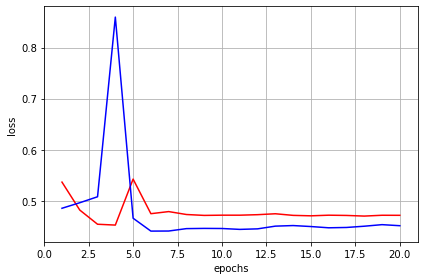

In [25]:
plt.plot(range(1, len(train_iterations)+1), train_losses, color='r')
plt.plot(range(1, len(val_iterations)+1), val_losses, color='b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_iterations)+1) # 일정한 scale
plt.grid(True)
plt.tight_layout()
plt.show()

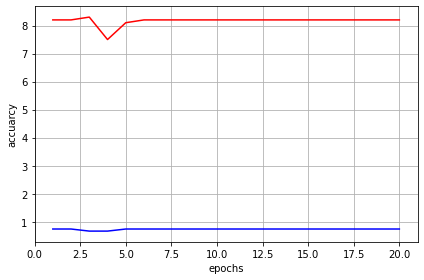

In [26]:
plt.plot(range(1, len(train_iterations)+1), train_accuracy_final , color='r')
plt.plot(range(1, len(val_iterations)+1), accuracy_final , color='b')
plt.xlabel('epochs')
plt.ylabel('accuarcy')
plt.xlim(0, len(train_iterations)+1) # 일정한 scale
plt.grid(True)
plt.tight_layout()
plt.show()